In [24]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc

from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, classification_report

In [25]:
torch.set_printoptions(profile="full")

In [26]:
import torch.nn as nn

# Define model
class Perceptron(torch.nn.Module):
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        self.layer = torch.nn.Linear(input_size, 8)
        self.layer2 = torch.nn.Linear(8, 8)
        self.sigmoid = torch.nn.ReLU()
        self.layer3 = torch.nn.Linear(8, 1)
        self.sigmoid3 = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.layer(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        x = self.layer3(x)
        x = self.sigmoid3(x)
        return x

In [27]:
import torch
import torch.nn as nn

class BrokenPerceptron(nn.Module):
    def __init__(self, input_size):
        super(BrokenPerceptron, self).__init__()
        self.layer = nn.Linear(input_size, 1)
        self.layer2 = nn.Linear(1, 1)
        self.sigmoid = nn.Sigmoid()
        self.layer3 = nn.Linear(1, 1)
        self.sigmoid3 = nn.Sigmoid()
        self.layer4 = nn.Linear(1, 1)
        self.sigmoid4 = nn.Sigmoid()
        self.layer5 = nn.Linear(1, 1)
        self.sigmoid5 = nn.Sigmoid()
        self.layer6 = nn.Linear(1, 1)
        self.sigmoid6 = nn.Sigmoid()
        
    def forward(self, x):
        x = self.layer(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        x = self.layer3(x)
        x = self.sigmoid3(x)
        x = self.layer4(x)
        x = self.sigmoid4(x)
        x = self.layer5(x)
        x = self.sigmoid5(x)
        x = self.layer6(x)
        x = self.sigmoid6(x)
        return x


Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.66      0.71       100
         1.0       0.70      0.81      0.75       100

    accuracy                           0.73       200
   macro avg       0.74      0.74      0.73       200
weighted avg       0.74      0.73      0.73       200

Accuracy: 0.7350
F1 Score: 0.7535
ROC AUC: 0.8082


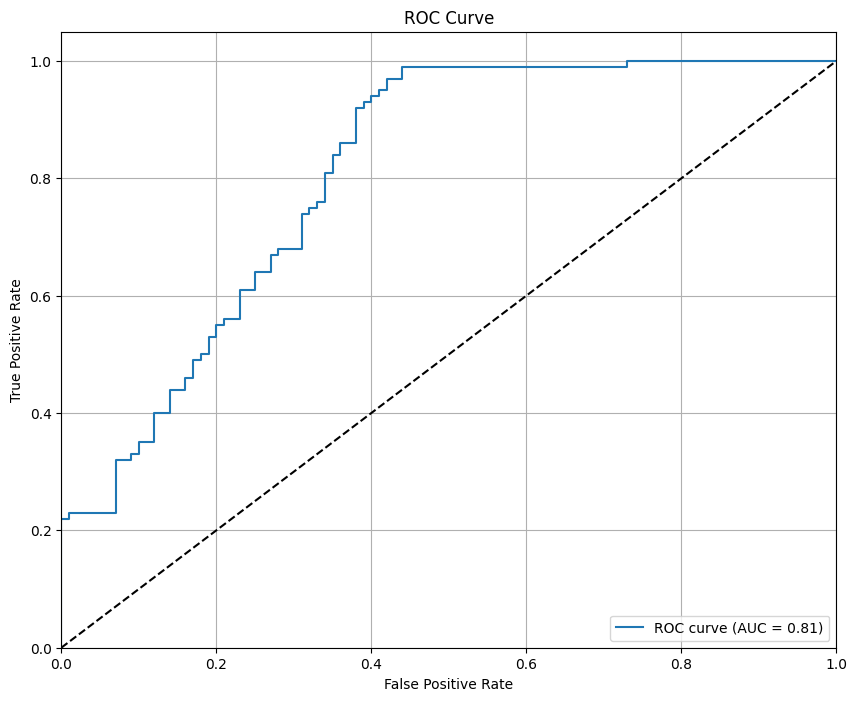

In [28]:
from analysys.gradients import extract_gradients_by_layer

X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# Initialize model, loss, and optimizer
model = Perceptron(X_train.shape[1])
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 50
losses = []

for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train)

    # Calculate loss
    loss = criterion(outputs.squeeze(), y_train)
    losses.append(loss.item())

    # Zero gradients
    optimizer.zero_grad()

    # Backward pass (here the gradients are actually computed)
    loss.backward()

    extract_gradients_by_layer(model)

    # Update weights
    optimizer.step()

# Evaluation
model.eval()

with torch.no_grad():
    y_pred = model(X_test)
    y_pred_class = (y_pred.squeeze() > 0.5).float()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test.numpy(), y_pred.squeeze().numpy())
    roc_auc = auc(fpr, tpr)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_class))

    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [29]:
def compute_eigen_of_hessian(hessian):
    eigenvalues, _ = torch.linalg.eigh(hessian)
    return eigenvalues

In [30]:
def visualize_curvature(hessian):
    eigenvalues = compute_eigen_of_hessian(hessian)
    plt.plot(eigenvalues.detach().cpu().numpy())
    plt.title("Собственные значения Гессиана")
    plt.xlabel("Индекс")
    plt.ylabel("Собственное значение")
    plt.show()

In [31]:
from hessian.hessian import HessianCalculator

hc = HessianCalculator(model, criterion)

/home/maxim/git/net-arch-research/hessian/hessian.py:16: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  self.fmodel, self.params = make_functional(model)


In [32]:
for i in range(len(X_train)):
    output = model(X_train[i])
    hessian = hc.hessian_wrt_params(X_train[i], output)
    print(hessian)
    print(compute_eigen_of_hessian(hessian))
    visualize_curvature(hessian)

    if i == 5:
        break

tensor([[ 5.6503e-05, -2.1949e-05, -4.2486e-05,  1.6504e-05, -1.7418e-03,
          6.7661e-04,  1.9585e-03, -7.6079e-04, -1.9730e-03,  7.6640e-04,
          1.6073e-03, -6.2434e-04, -4.3340e-03,  1.6835e-03, -3.0138e-03,
          1.1707e-03,  6.4946e-05, -4.8834e-05, -2.0021e-03,  2.2512e-03,
         -2.2678e-03,  1.8474e-03, -4.9816e-03, -3.4641e-03, -2.4924e-03,
         -1.3981e-03, -4.1726e-03, -5.9943e-03, -6.1888e-03, -8.2874e-03,
         -7.6656e-04, -5.6620e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -3.3849e-03, -1.8988e-03, -5.6668e-03, -8.1409e-03,
         -8.4050e-03, -1.1255e-02, -1.0411e-03, -7.6896e-03,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.

_LinAlgError: linalg.eigh: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated eigenvalues (error code: 9526).

# ПО ВХОДУ

tensor([[9.7379e-05, 9.5354e-04],
        [9.5354e-04, 9.3371e-03]])
tensor([7.2760e-12, 9.4345e-03])


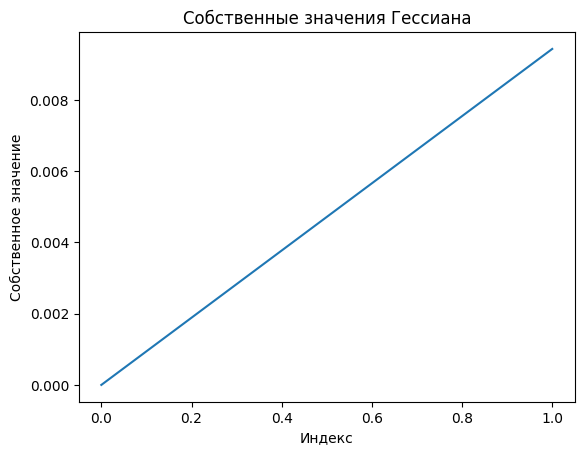

tensor([[0.0084, 0.0301],
        [0.0301, 0.1072]])
tensor([3.7253e-09, 1.1565e-01])


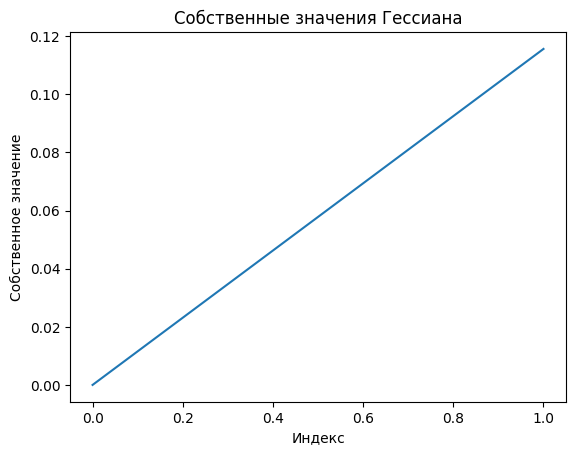

tensor([[0.0493, 0.0379],
        [0.0379, 0.0292]])
tensor([0.0000, 0.0785])


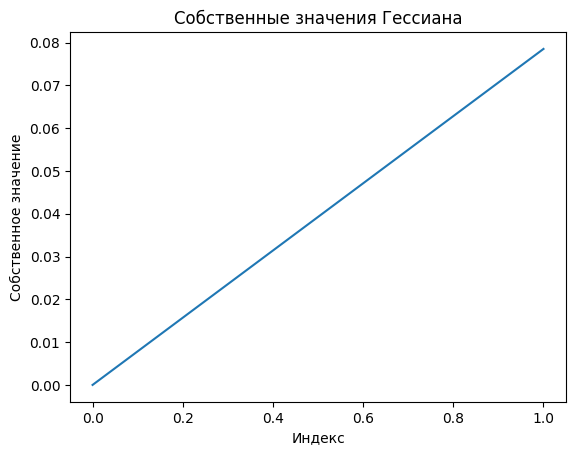

tensor([[0.0516, 0.0482],
        [0.0482, 0.0449]])
tensor([5.5879e-09, 9.6574e-02])


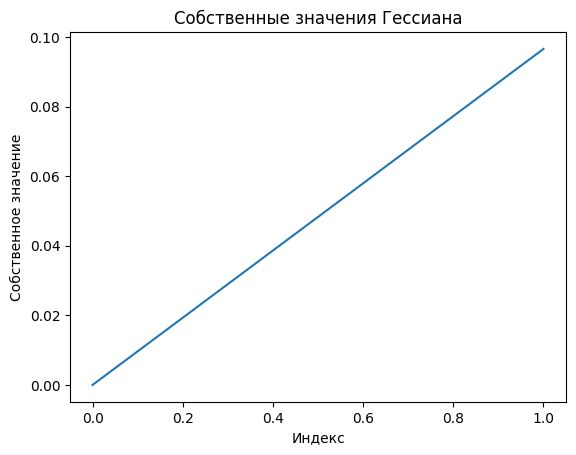

tensor([[ 0.0054, -0.0104],
        [-0.0104,  0.0202]])
tensor([-2.3283e-09,  2.5611e-02])


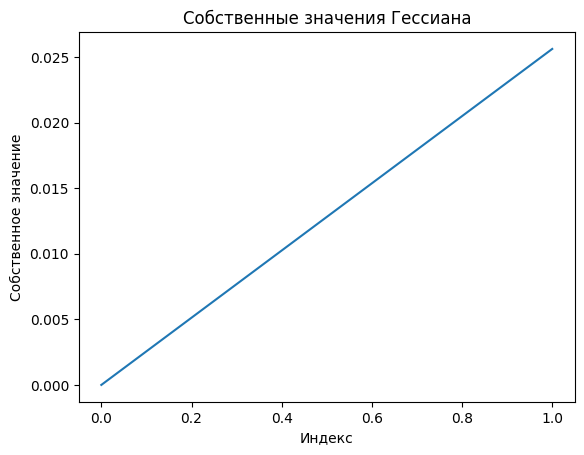

tensor([[0.0249, 0.0275],
        [0.0275, 0.0304]])
tensor([9.3132e-10, 5.5341e-02])


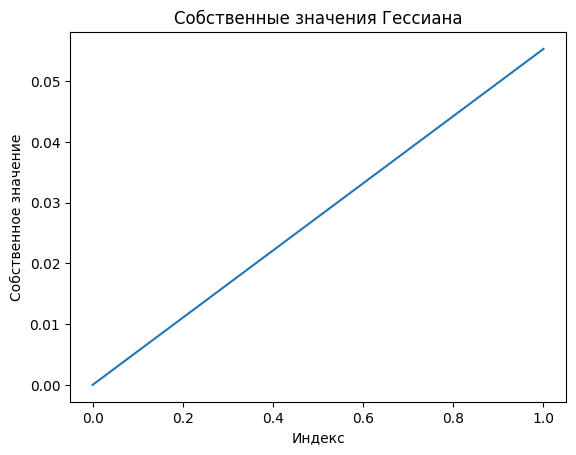

In [ ]:
for i in range(len(X_train)):
    output = model(X_train[i])
    hessian = hc.hessian_wrt_inputs(X_train[i], output)
    print(hessian)
    print(compute_eigen_of_hessian(hessian))
    visualize_curvature(hessian)

    if i == 5:
        break

# ПО СЛОЯМ - ПАРАМЕТРЫ

In [33]:
from hessian.layer_wise_hessian import compute_local_hessians_for_chunks

hess = compute_local_hessians_for_chunks(model, X_train[0])

for name, i in hess.items():
    print(f"Chunk idx {name} and hessian of layer chunk {i}")
    print(f"Eigenvalue of {name}'th hessian {compute_eigen_of_hessian(i)}")
    print("=" * 80)

Chunk idx 0 and hessian of layer chunk tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       

# Веса сети

In [22]:
for name, param in model.named_parameters():
    print(f"{name}:")
    print(param.data)
    print("="*50)

layer.weight:
tensor([[-1.0096,  0.6787],
        [-0.1944, -0.5605],
        [ 0.4094,  1.1247],
        [ 0.8899, -1.1653],
        [ 0.8635,  1.1818],
        [-0.2764, -0.9203],
        [-0.6042, -0.8619],
        [ 0.4665, -1.0582]])
layer.bias:
tensor([-0.8702, -0.4416,  1.0332,  0.0670,  0.9053, -1.1401,  0.2178,  0.7274])
layer2.weight:
tensor([[ 0.3890,  0.3450, -0.7171,  0.4507, -0.8122,  0.3727,  0.3872, -0.1143],
        [ 0.2227, -0.0671,  0.2295,  0.6702,  0.1865, -0.0398, -0.4651, -0.0375],
        [ 0.8033,  0.2551, -0.6672, -0.6706, -0.5773,  0.4557,  0.1696, -0.6795],
        [-0.7007,  0.0735,  0.0962,  0.7225, -0.0346, -0.2284,  0.7353,  0.6399],
        [ 0.1456,  0.1621, -0.0772, -0.1604, -0.1280,  0.0659,  0.1240,  0.0918],
        [-0.1704, -0.5932,  0.7037, -0.7159,  0.3033, -0.7604,  0.1126, -0.1546],
        [ 0.2875,  0.1410, -0.6871,  0.4562, -0.7781,  0.6569,  0.0121,  0.1011],
        [ 0.2458,  0.1321, -0.1808,  0.0224,  0.1969,  0.1251,  0.4056, -0.1012

In [23]:
from analisys.hessian import spectral_analysis, compute_condition_number

hess_list = list(hess.values())

spectral_analysis(hess_list, None)

ModuleNotFoundError: No module named 'analisys'

In [14]:
compute_condition_number(hess_list)

=== Число обусловленности для Layer 0 ===
λ_min: 0.000000, λ_max: 0.000000, κ: inf
=== Число обусловленности для Layer 1 ===
λ_min: -0.494026, λ_max: 0.593803, κ: -1.2019672393798828
=== Число обусловленности для Layer 2 ===
λ_min: -0.110888, λ_max: 0.000000, κ: -1.3122061659487372e-08


{'Layer 0': inf,
 'Layer 1': np.float32(-1.2019672),
 'Layer 2': np.float32(-1.3122062e-08)}